In [1]:
from StackOverflow import Stack_overflow_tool
from get_urls import get_url_tool
from summarizer import StackOverflowSummarizer
import json

In [2]:
from typing import Annotated, Dict, Any
from typing_extensions import TypedDict
from langchain_core.messages import SystemMessage, ToolMessage, HumanMessage, AIMessage, AnyMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import uuid

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [3]:
class Agent:
    def __init__(self, model, tools, system=""):
        self.model = model
        self.llm = model.bind_tools(tools)
        self.system = system
        self.tools = {t.name: t for t in tools}
        self.tool_names = [t.name for t in tools]

        # Build the state graph
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_groq)

        for tool in tools:
            graph.add_node(tool.name, self.take_action_for(tool.name))

        graph.add_node("refine_question", self.refine_question)
        graph.add_node("refine_answer", self.refine_answer)

        # Sequential chaining of tools (if needed)
        for x, y in zip(self.tool_names, self.tool_names[1:]):
            graph.add_edge(x, y)

        # Conditional branching based on result
        graph.add_conditional_edges(
            "llm",
            self.results_found,
            {
                "yes": self.tool_names[0],
                "no": "refine_question",
                "limit exceeded": END
            }
        )

        graph.add_edge("refine_question", "llm")
        graph.add_edge(self.tool_names[-1], "refine_answer")
        graph.add_edge("refine_answer", END)

        graph.set_entry_point("llm")
        self.graph = graph.compile()

    def call_groq(self, state: AgentState) -> AgentState:
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        response = self.llm.invoke(messages)
        return {"messages": [response]}

    def refine_question(self, state: AgentState) -> AgentState:
        last_msg = state["messages"][-1].content
        prompt = f"Refine the question: {last_msg} to be more specific and clear."
        messages = [SystemMessage(content=self.system), HumanMessage(content=prompt)]
        response = self.model.invoke(messages)
        return {"messages": [HumanMessage(content=response.content)]}

    def refine_answer(self, state: AgentState) -> AgentState:
        last_msg = state["messages"][-1].content
        prompt = f"Refine the answer: {last_msg} to be more specific and clear."
        messages = [SystemMessage(content=self.system), HumanMessage(content=prompt)]
        response = self.model.invoke(messages)
        return {"messages": [AIMessage(content=response.content)]}

    def results_found(self, state: AgentState) -> str:
        query = state["messages"][0].content
        try:
            tool_response = self.tools["get_url_tool"].invoke({"query": query})
            if tool_response:
                return "yes"
            else:
                return "no"
        except Exception as e:
            print("Tool call error:", e)
            return "limit exceeded"

    def take_action_for(self, tool_name):
        def _handler(state: AgentState):
            last_msg = state['messages'][-1]

            if isinstance(last_msg, AIMessage) and last_msg.tool_calls:
                messages = []
                tool_calls = last_msg.tool_calls

                for t in tool_calls:
                    if t['name'] == tool_name:
                        
                        print(f'Calling tool: {tool_name}')
                        results=[]
                        result = self.tools[t['name']].invoke(t['args'])
                        results.append(result)
                        messages.append(ToolMessage(
                            tool_call_id=t["id"],
                            name=t["name"],
                            content=str(result)
                        ))
                        if tool_name in self.tool_names:
                            idx = self.tool_names.index(tool_name)
                            
                            if idx + 1 < len(self.tool_names):
                                next_tool = self.tool_names[idx + 1]
                                arg = list(self.tools[next_tool].args_schema.model_json_schema()['properties'].keys())
                                args={}
                                if "query" in arg:
                                    args["query"]=state['messages'][0].content
                                    arg.remove("query")
                                for x,y in zip(arg,results):
                                    args[x]=y
                                messages.append(AIMessage(
                                    content=f"Triggering next tool: {next_tool}",
                                    tool_calls=[{
                                        "name": next_tool,
                                        "args": args,
                                        "id": f"synthetic-{next_tool}-{t['id']}"
                                    }]
                                ))

                return {
                    "messages": messages
                }

            return {}

        return _handler


In [4]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

model=ChatGroq(model="llama-3.3-70b-versatile")
model.invoke("How are you doing?")

AIMessage(content="I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to assist you with any questions or tasks you may have. How can I help you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 40, 'total_tokens': 86, 'completion_time': 0.167272727, 'prompt_time': 0.001881623, 'queue_time': 0.054889442000000004, 'total_time': 0.16915435}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None}, id='run-7088a8f6-dcb3-4ce1-8305-b6f3c8267c3f-0', usage_metadata={'input_tokens': 40, 'output_tokens': 46, 'total_tokens': 86})

In [5]:
abot=Agent(model,[get_url_tool,Stack_overflow_tool,StackOverflowSummarizer],system="You are a helpful assistant. You must make one tool call at a time.")

In [6]:
abot.graph.get_graph().draw_mermaid_png

<bound method Graph.draw_mermaid_png of Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'llm': Node(id='llm', name='llm', data=llm(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'get_url_tool': Node(id='get_url_tool', name='get_url_tool', data=get_url_tool(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'stack_overflow_tool': Node(id='stack_overflow_tool', name='stack_overflow_tool', data=stack_overflow_tool(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'StackOverflowSummarizer': Node(id='StackOverflowSummarizer', name='StackOverflowSummarizer', data=StackOverflowSummarizer(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'refine_question': Node(id='refine_questio

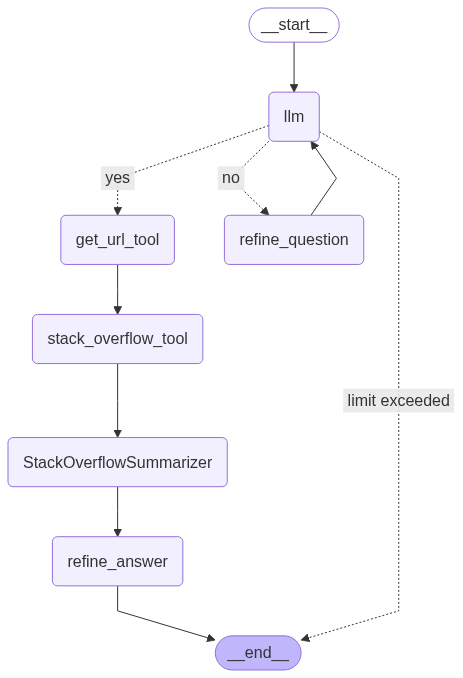

In [7]:
from IPython.display import Image, display

try:
    display(Image(abot.graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
messages=HumanMessage(content="How to reverse a string in Python?")
for event in abot.graph.stream({"messages": messages}):
    print(event)
    

{'llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_jn1q', 'function': {'arguments': '{"query":"reverse string in Python"}', 'name': 'get_url_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 621, 'total_tokens': 639, 'completion_time': 0.073316455, 'prompt_time': 0.047700424, 'queue_time': 0.054998837, 'total_time': 0.121016879}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f17f0dec-e21a-4138-857e-3145cd20df17-0', tool_calls=[{'name': 'get_url_tool', 'args': {'query': 'reverse string in Python'}, 'id': 'call_jn1q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 621, 'output_tokens': 18, 'total_tokens': 639})]}}
Calling tool: get_url_tool
{'get_url_tool': {'messages': [ToolMessage(content="['https://stackoverflow.com/questions/931092/how-do-i-reverse-a-string-in-python', 'https://stackoverfl

In [9]:
print(event['refine_answer']['messages'][0].content)

**Reversing a String in Python: Most Efficient Methods**

To reverse a string in Python, the following methods are highly recommended due to their efficiency and conciseness:

### 1. **Using Slicing with a Step of -1**

The most popular and efficient way to reverse a string is by using slicing with a step of -1. This can be achieved using the following syntax:
```python
s = "hello"
reversed_s = s[::-1]
print(reversed_s)  # Output: "olleh"
```
This method is concise, fast, and works by creating a new string that includes all characters from the original string, but in reverse order.

### 2. **Reversing a Substring with Slicing**

Another way to reverse a substring is by using slicing with a start and end index, and a step of -1. For example:
```python
s = "hello"
reversed_substring = s[4:1:-1]
print(reversed_substring)  # Output: "oll"
```
This method is slightly more verbose than the first one but still efficient.

### Other Methods

While the slicing method is generally the most effic